# Linear Regression Implementation from Scratch
:label:`sec_linear_scratch`

We are now ready to work through 
a fully functioning implementation 
of linear regression. 
In this section, 
(**we will implement the entire method from scratch,
including (i) the model; (ii) the loss function;
(iii) a minibatch stochastic gradient descent optimizer;
and (iv) the training function 
that stitches all of these pieces together.**)
Finally, we will run our synthetic data generator
from :numref:`sec_synthetic-regression-data`
and apply our model
on the resulting dataset. 
While modern deep learning frameworks 
can automate nearly all of this work,
implementing things from scratch is the only way
to make sure that you really know what you are doing.
Moreover, when it is time to customize models,
defining our own layers or loss functions,
understanding how things work under the hood will prove handy.
In this section, we will rely only 
on tensors and automatic differentiation.
Later, we will introduce a more concise implementation,
taking advantage of the bells and whistles of deep learning frameworks 
while retaining the structure of what follows below.


In [1]:
%matplotlib inline
import torch
from d2l import torch as d2l

## Defining the Model

[**Before we can begin optimizing our model's parameters**] by minibatch SGD,
(**we need to have some parameters in the first place.**)
In the following we initialize weights by drawing
random numbers from a normal distribution with mean 0
and a standard deviation of 0.01. 
The magic number 0.01 often works well in practice, 
but you can specify a different value 
through the argument `sigma`.
Moreover we set the bias to 0.
Note that for object-oriented design
we add the code to the `__init__` method of a subclass of `d2l.Module` (introduced in :numref:`subsec_oo-design-models`).


In [2]:
class LinearRegressionScratch(d2l.Module):  #@save
    """The linear regression model implemented from scratch."""
    def __init__(self, num_inputs, lr, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.w = torch.normal(0, sigma, (num_inputs, 1), requires_grad=True)
        self.b = torch.zeros(1, requires_grad=True)

Next we must [**define our model,
relating its input and parameters to its output.**]
Using the same notation as :eqref:`eq_linreg-y-vec`
for our linear model we simply take the matrix--vector product
of the input features $\mathbf{X}$ 
and the model weights $\mathbf{w}$,
and add the offset $b$ to each example.
The product $\mathbf{Xw}$ is a vector and $b$ is a scalar.
Because of the broadcasting mechanism 
(see :numref:`subsec_broadcasting`),
when we add a vector and a scalar,
the scalar is added to each component of the vector.
The resulting `forward` method 
is registered in the `LinearRegressionScratch` class
via `add_to_class` (introduced in :numref:`oo-design-utilities`).


In [3]:
@d2l.add_to_class(LinearRegressionScratch)  #@save
def forward(self, X):
    return torch.matmul(X, self.w) + self.b

## Defining the Loss Function

Since [**updating our model requires taking
the gradient of our loss function,**]
we ought to (**define the loss function first.**)
Here we use the squared loss function
in :eqref:`eq_mse`.
In the implementation, we need to transform the true value `y`
into the predicted value's shape `y_hat`.
The result returned by the following method
will also have the same shape as `y_hat`. 
We also return the averaged loss value
among all examples in the minibatch.


In [4]:
@d2l.add_to_class(LinearRegressionScratch)  #@save
def loss(self, y_hat, y):
    l = (y_hat - y) ** 2 / 2
    return l.mean()

## Defining the Optimization Algorithm

As discussed in :numref:`sec_linear_regression`,
linear regression has a closed-form solution.
However, our goal here is to illustrate 
how to train more general neural networks,
and that requires that we teach you 
how to use minibatch SGD.
Hence we will take this opportunity
to introduce your first working example of SGD.
At each step, using a minibatch 
randomly drawn from our dataset,
we estimate the gradient of the loss
with respect to the parameters.
Next, we update the parameters
in the direction that may reduce the loss.

The following code applies the update, 
given a set of parameters, a learning rate `lr`.
Since our loss is computed as an average over the minibatch, 
we do not need to adjust the learning rate against the batch size. 
In later chapters we will investigate 
how learning rates should be adjusted
for very large minibatches as they arise 
in distributed large-scale learning.
For now, we can ignore this dependency.


We define our `SGD` class,
a subclass of `d2l.HyperParameters` (introduced in :numref:`oo-design-utilities`),
to have a similar API 
as the built-in SGD optimizer.
We update the parameters in the `step` method.
The `zero_grad` method sets all gradients to 0,
which must be run before a backpropagation step.


In [5]:
class SGD(d2l.HyperParameters):  #@save
    """Minibatch stochastic gradient descent."""
    def __init__(self, params, lr):
        self.save_hyperparameters()

    def step(self):
        for param in self.params:
            param -= self.lr * param.grad

    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                param.grad.zero_()

We next define the `configure_optimizers` method, which returns an instance of the `SGD` class.


In [6]:
@d2l.add_to_class(LinearRegressionScratch)  #@save
def configure_optimizers(self):
    return SGD([self.w, self.b], self.lr)

## Training

Now that we have all of the parts in place
(parameters, loss function, model, and optimizer),
we are ready to [**implement the main training loop.**]
It is crucial that you understand this code fully
since you will employ similar training loops
for every other deep learning model
covered in this book.
In each *epoch*, we iterate through 
the entire training dataset, 
passing once through every example
(assuming that the number of examples 
is divisible by the batch size). 
In each *iteration*, we grab a minibatch of training examples,
and compute its loss through the model's `training_step` method. 
Then we compute the gradients with respect to each parameter. 
Finally, we will call the optimization algorithm
to update the model parameters. 
In summary, we will execute the following loop:

* Initialize parameters $(\mathbf{w}, b)$
* Repeat until done
    * Compute gradient $\mathbf{g} \leftarrow \partial_{(\mathbf{w},b)} \frac{1}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} l(\mathbf{x}^{(i)}, y^{(i)}, \mathbf{w}, b)$
    * Update parameters $(\mathbf{w}, b) \leftarrow (\mathbf{w}, b) - \eta \mathbf{g}$
 
Recall that the synthetic regression dataset 
that we generated in :numref:``sec_synthetic-regression-data`` 
does not provide a validation dataset. 
In most cases, however, 
we will want a validation dataset 
to measure our model quality. 
Here we pass the validation dataloader 
once in each epoch to measure the model performance.
Following our object-oriented design,
the `prepare_batch` and `fit_epoch` methods
are registered in the `d2l.Trainer` class
(introduced in :numref:`oo-design-training`).


In [7]:
@d2l.add_to_class(d2l.Trainer)  #@save
def prepare_batch(self, batch):
    return batch

In [8]:
@d2l.add_to_class(d2l.Trainer)  #@save
def fit_epoch(self):
    self.model.train()
    for batch in self.train_dataloader:
        loss = self.model.training_step(self.prepare_batch(batch))
        self.optim.zero_grad()
        with torch.no_grad():
            loss.backward()
            if self.gradient_clip_val > 0:  # To be discussed later
                self.clip_gradients(self.gradient_clip_val, self.model)
            self.optim.step()
        self.train_batch_idx += 1
    if self.val_dataloader is None:
        return
    self.model.eval()
    for batch in self.val_dataloader:
        with torch.no_grad():
            self.model.validation_step(self.prepare_batch(batch))
        self.val_batch_idx += 1

We are almost ready to train the model,
but first we need some training data.
Here we use the `SyntheticRegressionData` class 
and pass in some ground truth parameters.
Then we train our model with 
the learning rate `lr=0.03` 
and set `max_epochs=3`. 
Note that in general, both the number of epochs 
and the learning rate are hyperparameters.
In general, setting hyperparameters is tricky
and we will usually want to use a three-way split,
one set for training, 
a second for hyperparameter selection,
and the third reserved for the final evaluation.
We elide these details for now but will revise them
later.


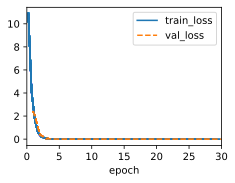

In [10]:
model = LinearRegressionScratch(2, lr=0.03)
data = d2l.SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)
trainer = d2l.Trainer(max_epochs=30)
trainer.fit(model, data)

Because we synthesized the dataset ourselves,
we know precisely what the true parameters are.
Thus, we can [**evaluate our success in training
by comparing the true parameters
with those that we learned**] through our training loop.
Indeed they turn out to be very close to each other.


In [11]:
with torch.no_grad():
    print(f'error in estimating w: {data.w - model.w.reshape(data.w.shape)}')
    print(f'error in estimating b: {data.b - model.b}')

error in estimating w: tensor([-0.0005,  0.0004])
error in estimating b: tensor([0.0002])


We should not take the ability to exactly recover 
the ground truth parameters for granted.
In general, for deep models unique solutions
for the parameters do not exist,
and even for linear models,
exactly recovering the parameters
is only possible when no feature 
is linearly dependent on the others.
However, in machine learning, 
we are often less concerned
with recovering true underlying parameters,
but rather with parameters 
that lead to highly accurate prediction :cite:`Vapnik.1992`.
Fortunately, even on difficult optimization problems,
stochastic gradient descent can often find remarkably good solutions,
owing partly to the fact that, for deep networks,
there exist many configurations of the parameters
that lead to highly accurate prediction.


## Summary

In this section, we took a significant step 
towards designing deep learning systems 
by implementing a fully functional 
neural network model and training loop.
In this process, we built a data loader, 
a model, a loss function, an optimization procedure,
and a visualization and monitoring tool. 
We did this by composing a Python object 
that contains all relevant components for training a model. 
While this is not yet a professional-grade implementation
it is perfectly functional and code like this 
could already help you to solve small problems quickly.
In the coming sections, we will see how to do this
both *more concisely* (avoiding boilerplate code)
and *more efficiently* (using our GPUs to their full potential).



## Exercises

1. What would happen if we were to initialize the weights to zero. Would the algorithm still work? What if we
   initialized the parameters with variance $1000$ rather than $0.01$?
1. Assume that you are [Georg Simon Ohm](https://en.wikipedia.org/wiki/Georg_Ohm) trying to come up
   with a model for resistance that relates voltage and current. Can you use automatic
   differentiation to learn the parameters of your model?
1. Can you use [Planck's Law](https://en.wikipedia.org/wiki/Planck%27s_law) to determine the temperature of an object
   using spectral energy density? For reference, the spectral density $B$ of radiation emanating from a black body is
   $B(\lambda, T) = \frac{2 hc^2}{\lambda^5} \cdot \left(\exp \frac{h c}{\lambda k T} - 1\right)^{-1}$. Here
   $\lambda$ is the wavelength, $T$ is the temperature, $c$ is the speed of light, $h$ is Planck's constant, and $k$ is the
   Boltzmann constant. You measure the energy for different wavelengths $\lambda$ and you now need to fit the spectral
   density curve to Planck's law.
1. What are the problems you might encounter if you wanted to compute the second derivatives of the loss? How would
   you fix them?
1. Why is the `reshape` method needed in the `loss` function?
1. Experiment using different learning rates to find out how quickly the loss function value drops. Can you reduce the
   error by increasing the number of epochs of training?
1. If the number of examples cannot be divided by the batch size, what happens to `data_iter` at the end of an epoch?
1. Try implementing a different loss function, such as the absolute value loss `(y_hat - d2l.reshape(y, y_hat.shape)).abs().sum()`.
    1. Check what happens for regular data.
    1. Check whether there is a difference in behavior if you actively perturb some entries, such as $y_5 = 10000$, of $\mathbf{y}$.
    1. Can you think of a cheap solution for combining the best aspects of squared loss and absolute value loss?
       Hint: how can you avoid really large gradient values?
1. Why do we need to reshuffle the dataset? Can you design a case where a maliciously constructed dataset would break the optimization algorithm otherwise?


[Discussions](https://discuss.d2l.ai/t/43)
